In [75]:
""" Resize the notbook to full width, to fit more code and images """
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
""" some basic packages and settings to show images inline """
import numpy as np
import importlib
%matplotlib inline
import matplotlib.pyplot as plt
""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2
""" Controls for figure sizes to change """
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams.update({'errorbar.capsize': 1})

from triplet import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
net = load_net('./models/net_class.pl') # load pretrained classification network
# net = load_net('./models/net_triplet.pl') # load pretrained classification network

# qery test images, use all test set to retrive
torch.manual_seed(0)
loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True, num_workers=0)
queries, qlabels = next(iter(loader))
#

In [3]:
net

ConvNet(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU(inplace=True)
  (8): AdaptiveAvgPool2d(output_size=(2, 2))
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=256, out_features=10, bias=True)
)

## Part 1

### Step 1

In [4]:
loader_whole_set = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True, num_workers=0)
for x_local, y_local in loader_whole_set:
    x = x_local
    y = y_local
features = net.features(x)
features.shape

torch.Size([1004, 256])

I didn't understand how to reduce computations utlizing the fact that the vectors are normalized. The only idea I got is to compute an angle via 

theta = arccos(a * b / (|a| * |b|)) = arccos(a * b / (1 * 1)) = arccos(a * b),

where * means dot product. We can use an angle for comparison or deduce the distance using the angle. But I'm not sure if that would me more computationally efficient

So I just did straigtforward computations

In [5]:
features_np = features.detach().numpy()
differences = np.expand_dims(features_np, 1) - np.expand_dims(features_np, 0)
differences.shape

(1004, 1004, 256)

Distance of every features with every feature

In [6]:
distances = np.linalg.norm(differences, axis=2)
distances.shape

(1004, 1004)

Finally, the indices of the 50 nearest features

In [7]:
nearest_indices = np.argsort(distances, axis=1)[:, :50]
nearest_indices.shape

(1004, 50)

Normalizing x (needed for pyplot)

In [8]:
x_norm = (x + 1) / 2
torch.min(x_norm), torch.max(x_norm)

(tensor(0.), tensor(1.))

The plot looks okay

<Figure size 3200x800 with 0 Axes>

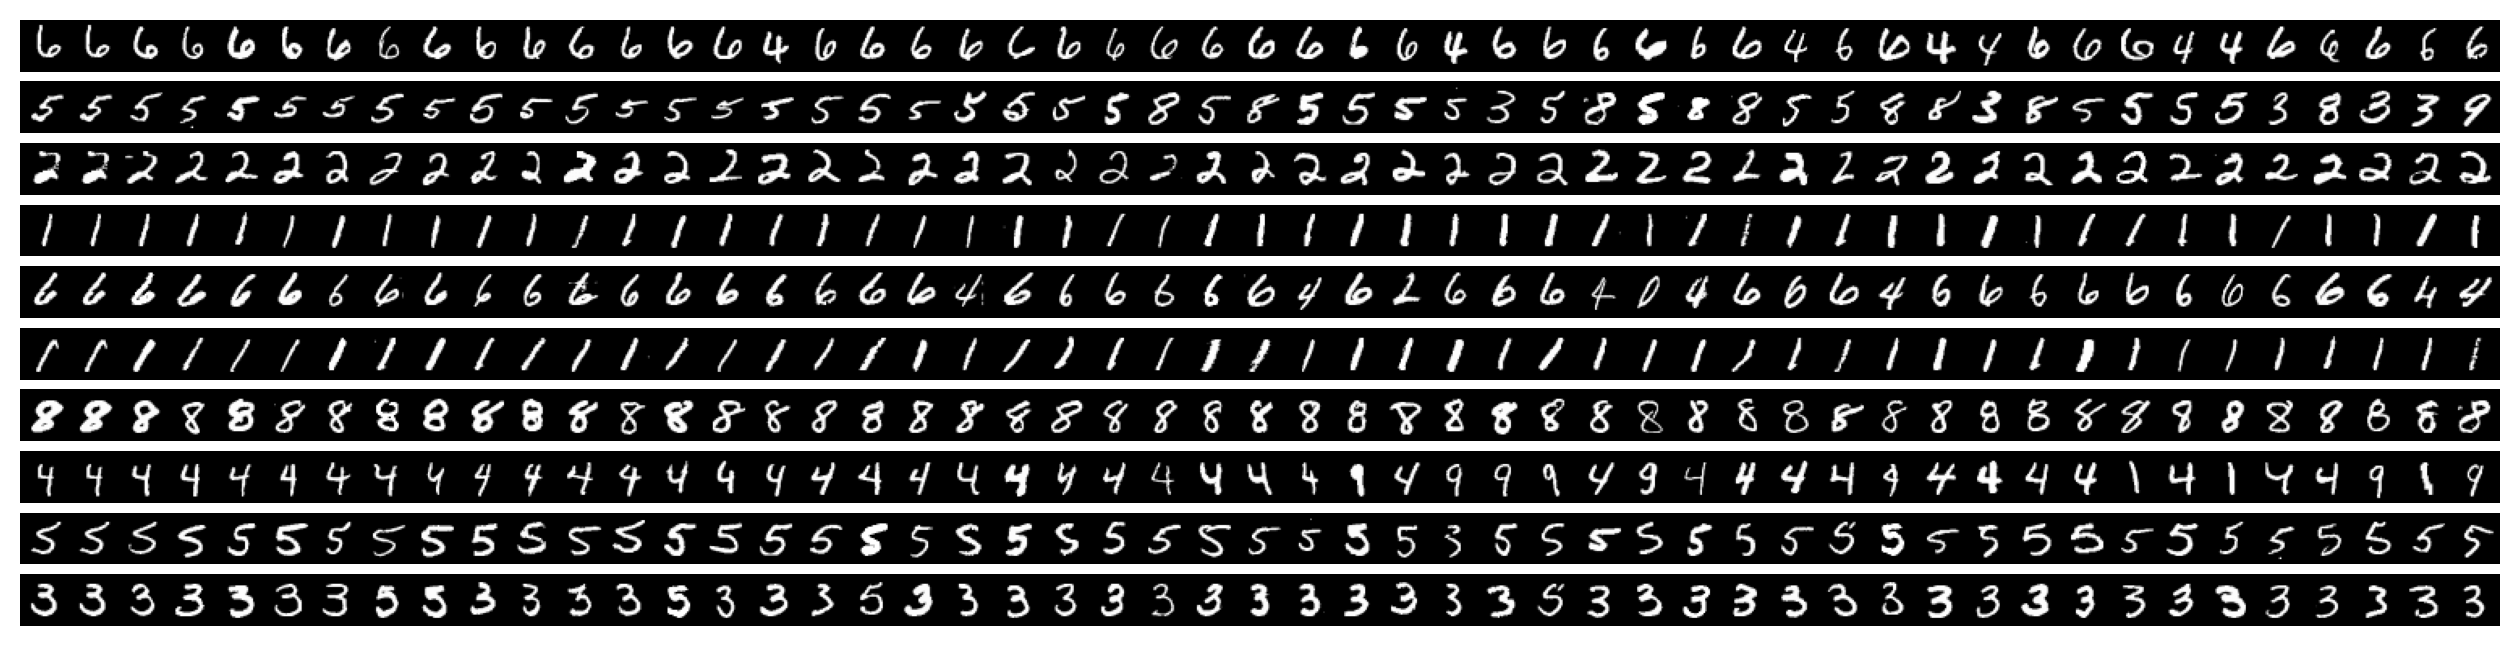

In [9]:
n = 50
queries_to_plot = 10

from torchvision.utils import make_grid

plt.clf()
f, axarr = plt.subplots(queries_to_plot, 1, gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(queries_to_plot):
    ax = axarr[i]
    # show retrived images for query i
    ax.axis('off')
    concat = torch.cat((x_norm[[i]], x_norm[nearest_indices[i]]), dim=0)
    grid = make_grid(concat, nrow=n+1)
    grid_np = grid.detach().numpy().transpose(1, 2, 0)
    ax.imshow(grid_np, cmap="viridis");

### Step 2

Classes have a different amount of samples. Did I misunderstand something?

In [10]:
y_np = y.detach().numpy()
_, counts = np.unique(y_np, return_counts=True)
counts

array([ 98, 114, 104, 101,  99,  90,  96, 103,  98, 101])

We'll need some auxiliary functions

In [11]:
def extract_x_y(dataset):
    for x, y in torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=0):
        return x, y
    
def get_indices_of_nearest_features(net, x):
    features = net.features(x).detach().numpy()
    differences = np.expand_dims(features, 1) - np.expand_dims(features, 0)
    distances = np.linalg.norm(differences, axis=2)
    return np.argsort(distances, axis=1)

P.S. At the moment I was writing that I didn't know templates for those functions are provided, so I wrote my own functions

Mean average precision: 0.74


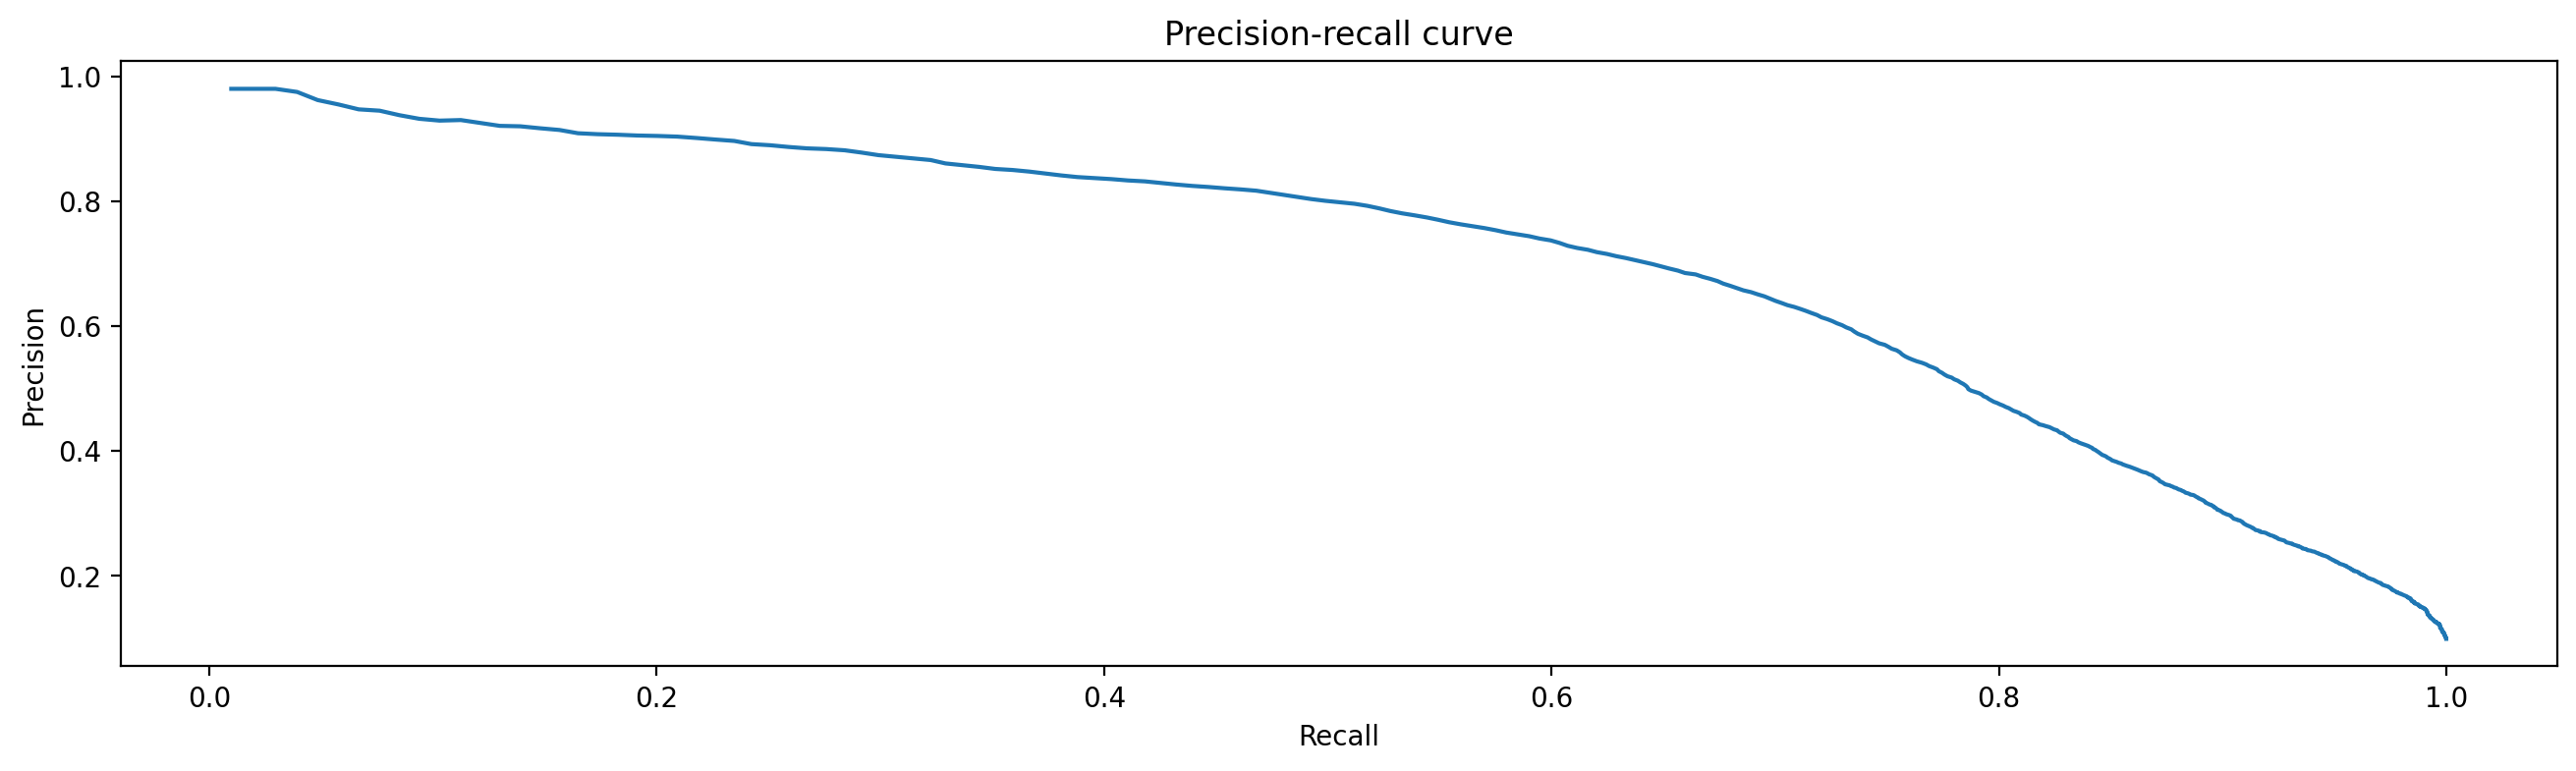

In [20]:
rng = np.random.default_rng()

def my_evaluate_AP(y, y_query, class_cardinality):
    rel = (y == y_query).astype("int")
    cs = np.cumsum(rel)
    prec = cs / np.arange(1, 1 + len(rel))
    recall_delta = rel / class_cardinality
    return np.sum(prec * recall_delta), prec, cs / class_cardinality

def my_evaluate_mAP(net, dataset, n_samples=100):
    x, y = extract_x_y(dataset)
    y = y.detach().numpy()
    unique, counts = np.unique(y, return_counts=True)
    nearest_indices = get_indices_of_nearest_features(net, x)
    random_indices = rng.integers(len(y), size=n_samples)
    
    mAP = 0
    mprec = np.zeros(len(y) - 1)
    mrec = prec = np.zeros(len(y) - 1)
    
    for i in random_indices:
        class_cardinality = counts[np.argwhere(unique == y[i])[0]]
        # excluding the query
        AP, prec, rec = my_evaluate_AP(y[nearest_indices[i]][1:], y[i], class_cardinality - 1)
        mAP += AP
        mprec += prec
        mrec += rec
        
    return mAP / n_samples, mprec / n_samples, mrec / n_samples

mAP, mprec, mrec = my_evaluate_mAP(net, test_set)
print(f"Mean average precision: {mAP:.2f}")

plt.plot(mrec, mprec)
plt.title("Precision-recall curve")
plt.ylabel("Precision")
plt.xlabel("Recall");

## Part 2

Just as a side question, why don't we average the triplet loss across different anchors (queries)? It would make the loss independent on the number of anchors

Also interesting note. Below are runs on my own PC CPU and on the FEL's GPU. There's almost no difference in time. Did I misunderstand something? The code is using minimum loops and mostly vectorized operations on tensors

P.S. I've run it for more epochs (10) and the GPU was literally 7s slower 0_0. My guess is that it probably needs bigger batches to fully utilizie paralelismus of GPU, but I don't have time to test it

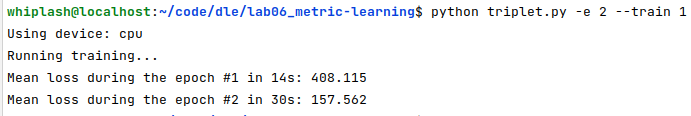

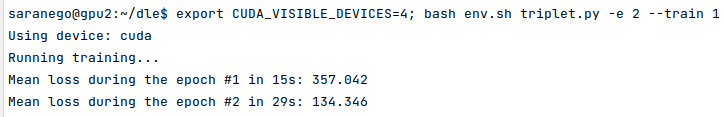

So, the report:

The optimization settings are triplet loss with alpha 0.5, SGD with lr=0.001, epochs=100

Training plot:

Using device: cpu


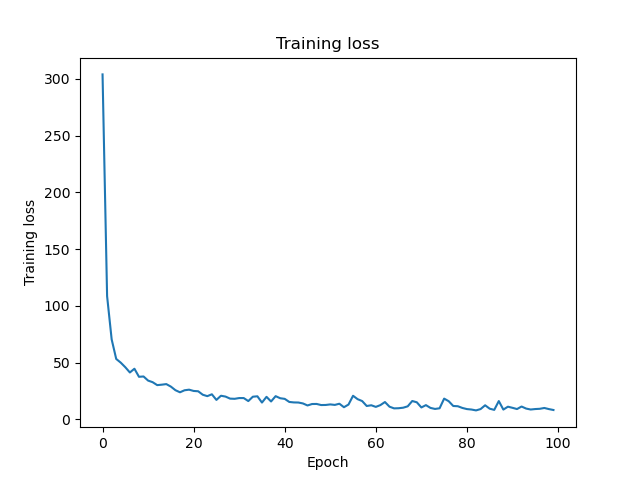

In [182]:
from IPython.display import Image, display
display(Image(filename="training_loss.png"))

Examples of retrieval of the trained network. As we can see, there is an obvious improvement. For example, the first row doesn't containt any digits other than query

<Figure size 3200x800 with 0 Axes>

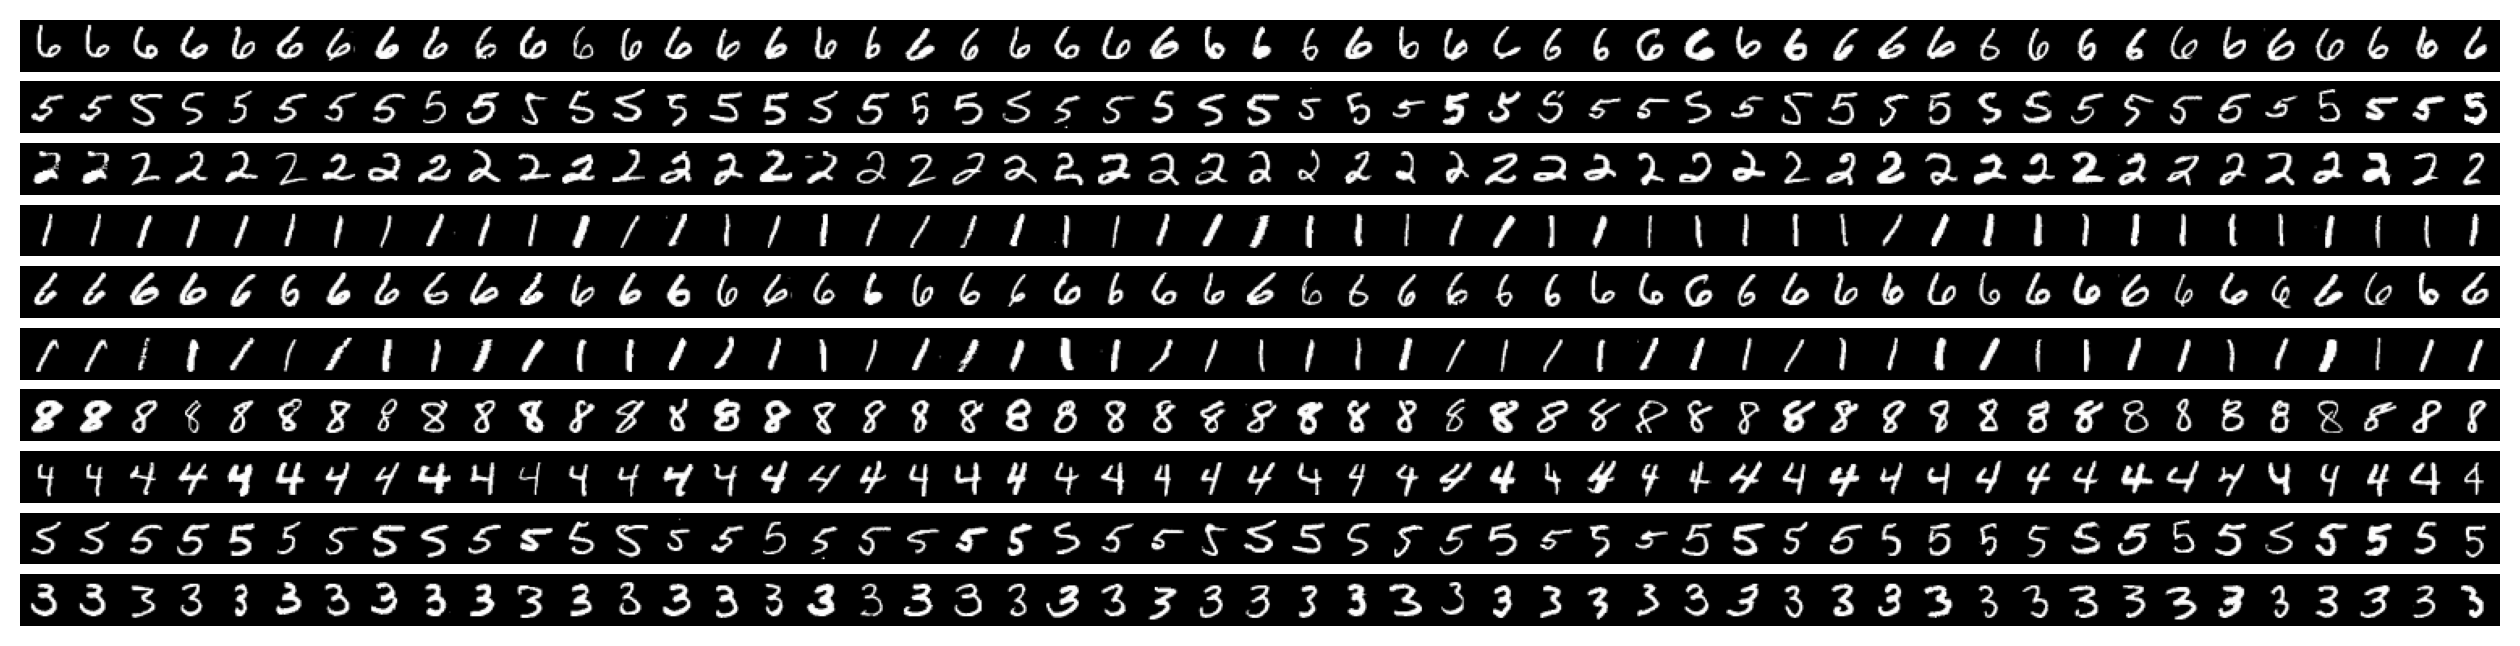

In [188]:
queries_to_plot = 10

net = ConvNet(10)
net.load_state_dict(torch.load(model_names[1]))
indices = get_indices_of_nearest_features(net, x)

plt.clf()
f, axarr = plt.subplots(queries_to_plot, 1, gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(queries_to_plot):
    ax = axarr[i]
    # show retrived images for query i
    ax.axis('off')
    concat = torch.cat((x_norm[[i]], x_norm[indices[i][:50]]), dim=0)
    grid = make_grid(concat, nrow=n+1)
    grid_np = grid.detach().numpy().transpose(1, 2, 0)
    ax.imshow(grid_np, cmap="viridis");

mAP, precision-recall curves

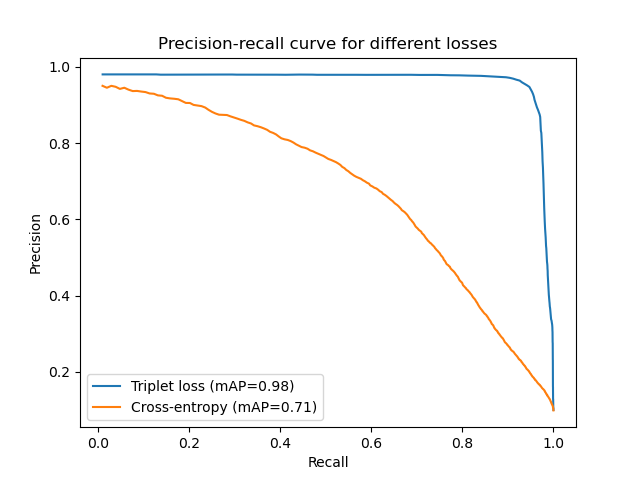

In [183]:
display(Image(filename="precision_recall.png"))

Next let's compare the t-SNE embeddings

In [184]:
net_class = ConvNet(10)
net_class.load_state_dict(torch.load(model_names[0], map_location=torch.device("cpu")))
indices_class = get_indices_of_nearest_features(net, x)
features_class = net_class.features(x)

I think it's better to try different perplexity values as they can capture local/global structure

P.S. I don't know why the legend seems to be not displaying

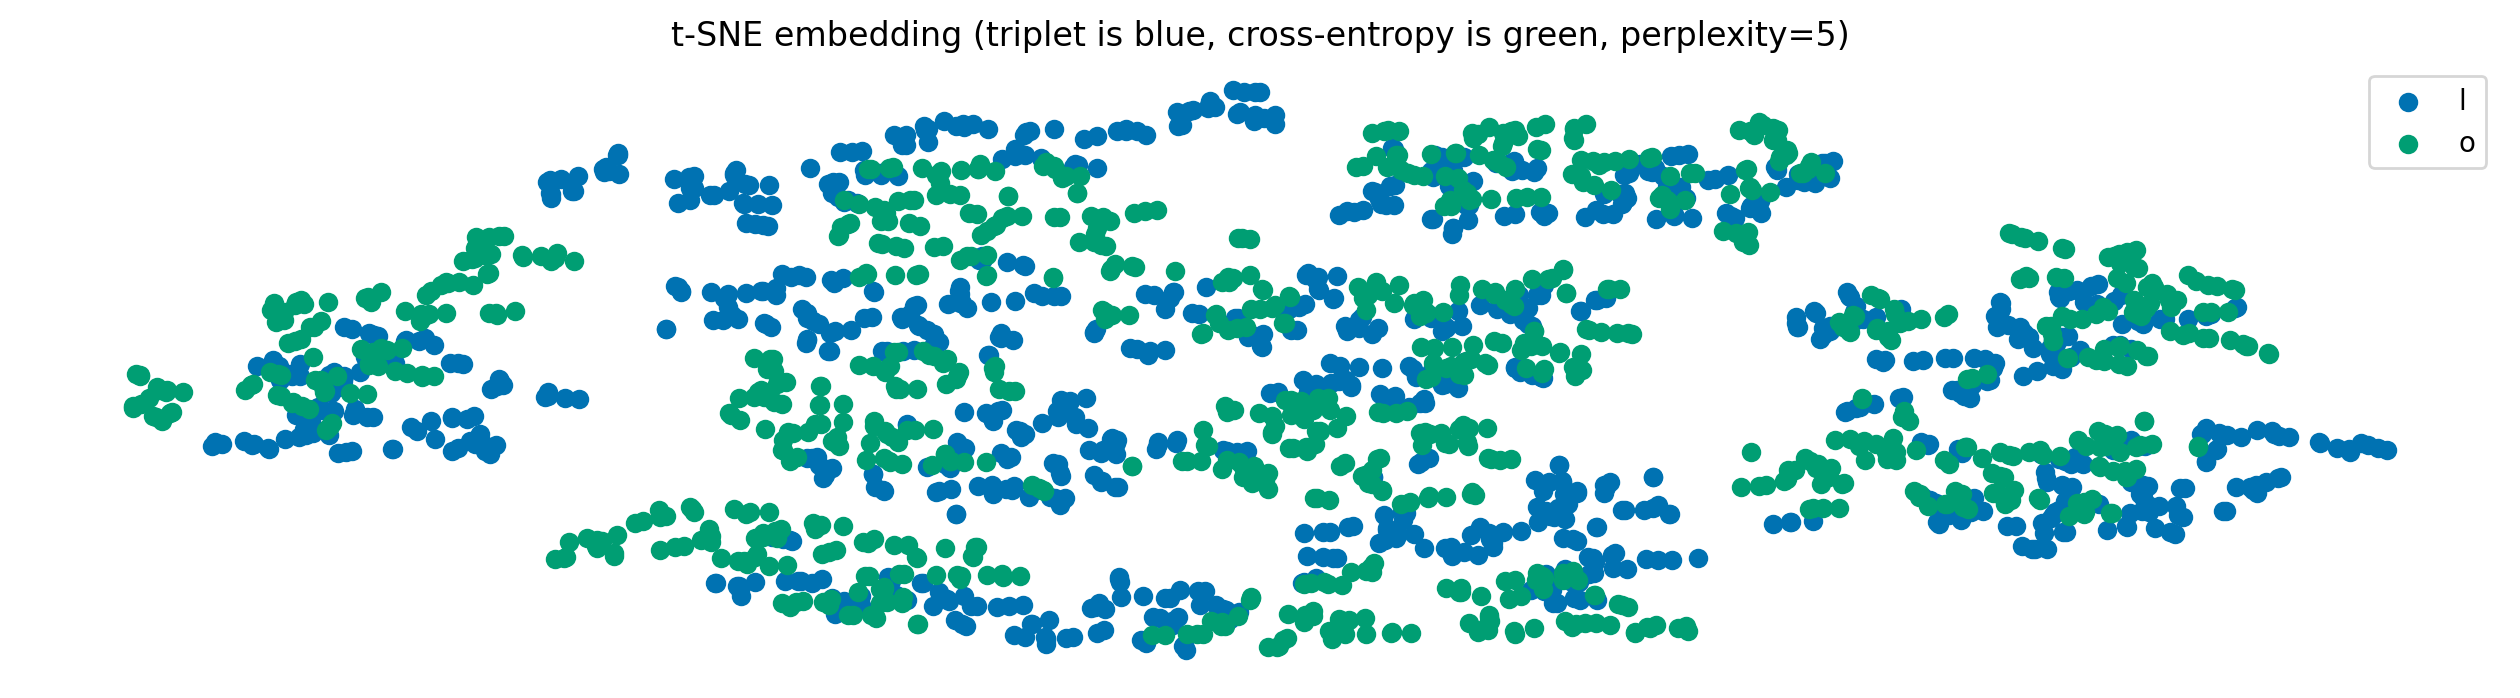

In [185]:
from sklearn.manifold import TSNE

def plot_tsne(perplexity):
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity)
    tsne_triplet = tsne.fit_transform(features.detach().numpy())
    tsne_class = tsne.fit_transform(features_class.detach().numpy())

    plt.style.use('seaborn-colorblind')
    plt.scatter(tsne_class[:, 0], tsne_class[:, 1], label="Cross-entropy")
    plt.scatter(tsne_triplet[:, 0], tsne_triplet[:, 1], label="Triplet")
    plt.title(f"t-SNE embedding (triplet is blue, cross-entropy is green, perplexity={perplexity})")
    plt.axis("off");
    plt.legend("lower left")
    
plot_tsne(perplexity=5)

The only t-SNE embeddings with perplexity 20 have some pattern (10 clusters). But I can't 100% say from this picture that triplet loss is better

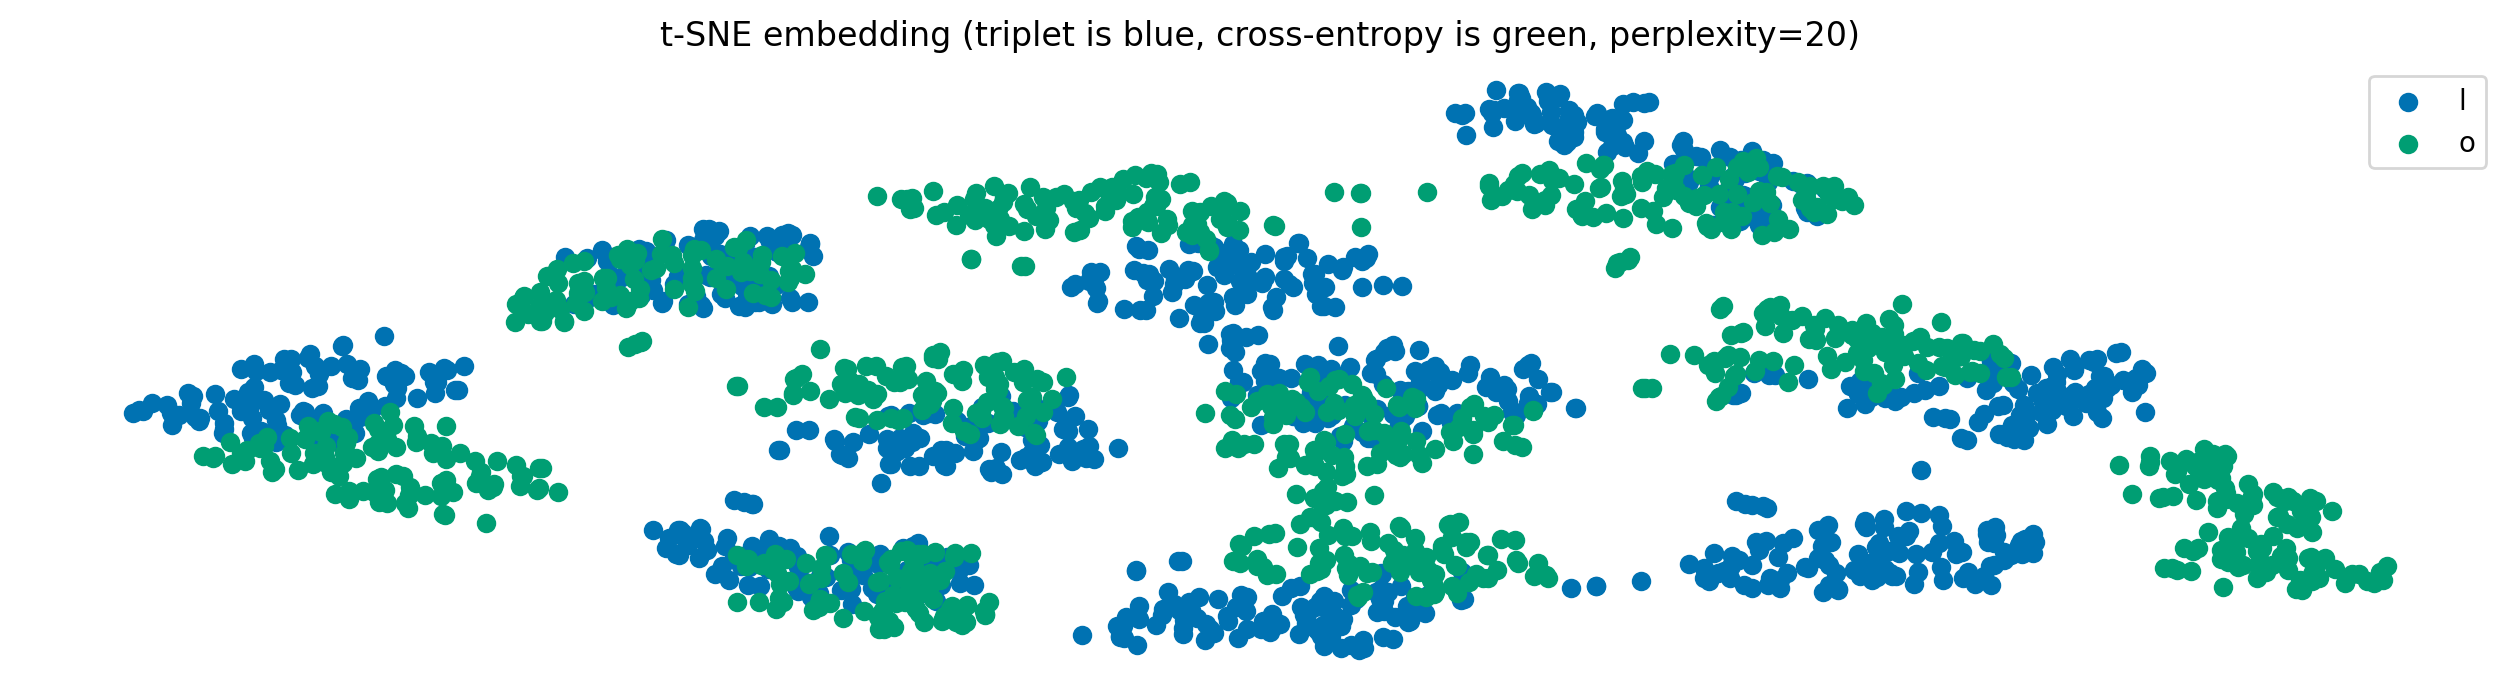

In [186]:
plot_tsne(perplexity=20)

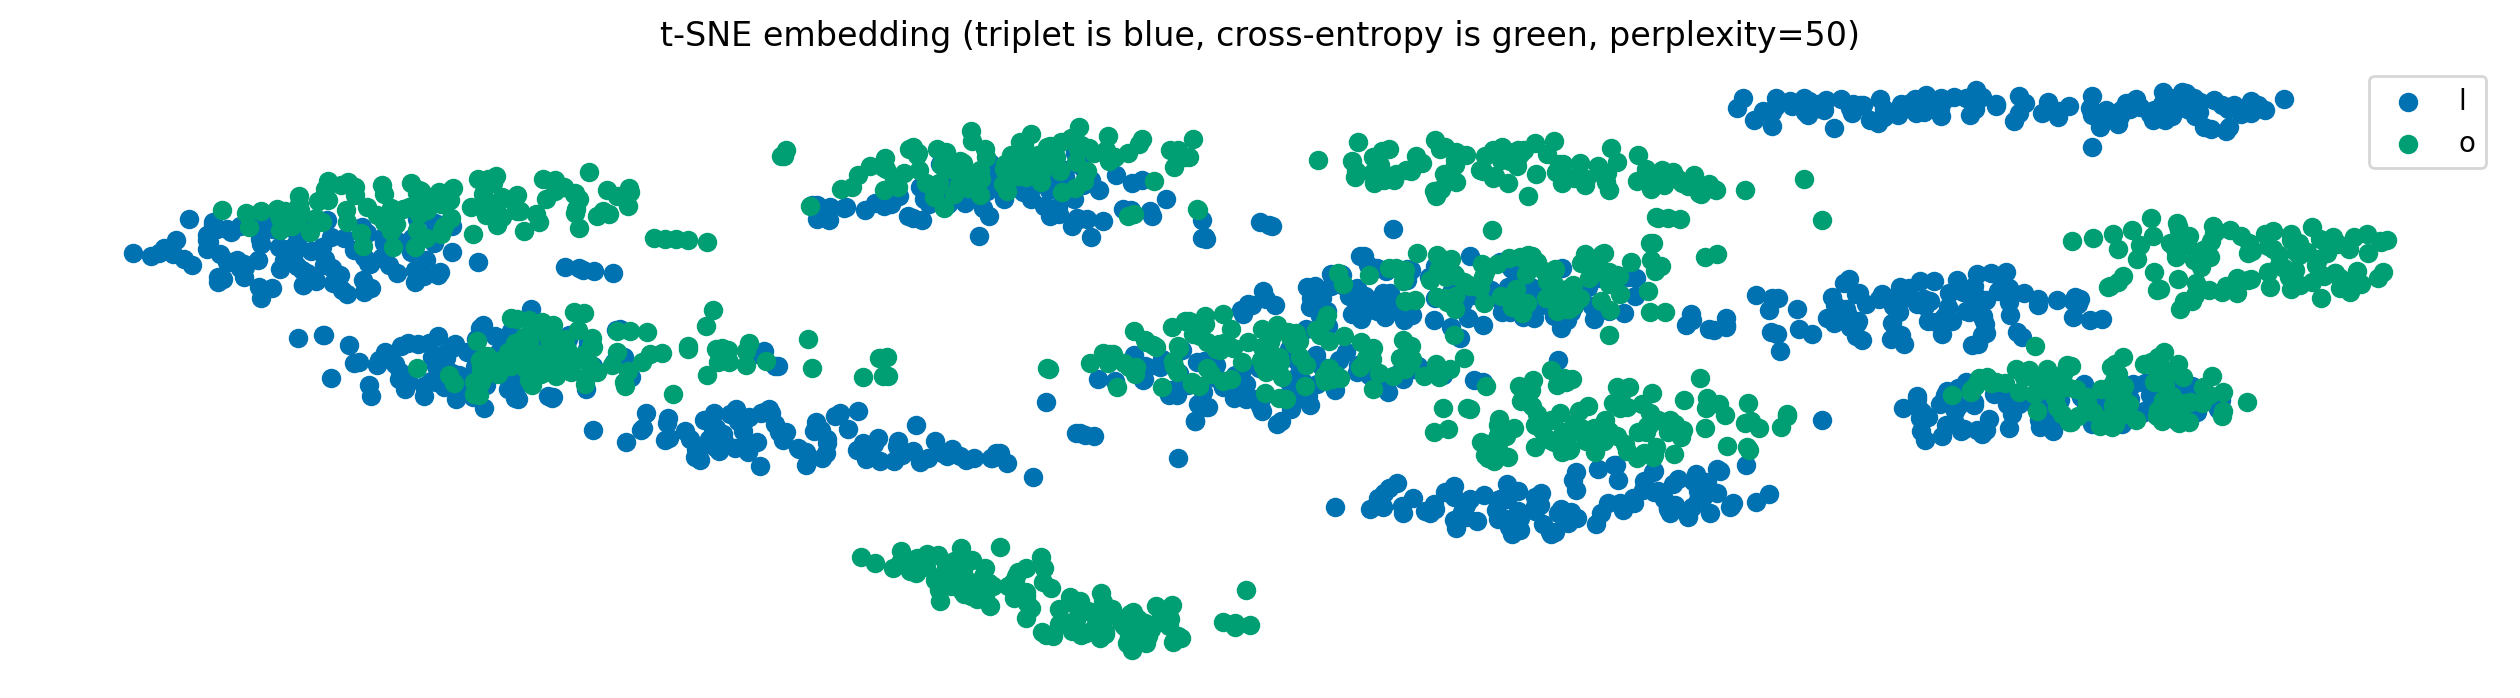

In [187]:
plot_tsne(perplexity=50)